## Random Forest

In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pickle

In [3]:
train = pd.read_csv('./dataset_diabetes/new_train.csv', index_col='encounter_id')
test = pd.read_csv('./dataset_diabetes/new_test.csv', index_col='encounter_id')

In [4]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [87]:
Xtrain = train.drop('readmitted_Yes', axis=1)
ytrain = train['readmitted_Yes']

In [88]:
Xtest = test.drop('readmitted_Yes', axis=1)
ytest = test['readmitted_Yes']

In [14]:
# Create placeholders for the results
min_split = []
scores = []
min_leaf = []

# Set optimization parameters
m_smpl = np.linspace(start=10, stop=100,num=91, dtype='int')
m_lf = np.linspace(2, 7, num=6, dtype='int')

# Run optimization
for smpl in m_smpl:
    for lf in m_lf:
        tree = RandomForestClassifier(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)
        cv = cross_val_score(tree, Xtrain, ytrain, cv = 10)
        score = np.mean(cv)
        min_split = min_split + [smpl]
        min_leaf = min_leaf + [lf]
        scores = scores + [score]

In [15]:
tmp_ = pd.DataFrame({'score':scores, 'smpl':min_split, 'leaf':min_leaf})

In [16]:
tmp_ = tmp_.sort_values('score', ascending=False).head(20)
tmp_

,score,smpl,leaf
49,0.886744,18,3
192,0.886681,42,2
108,0.886657,28,2
114,0.886657,29,2
156,0.886657,36,2
103,0.886657,27,3
147,0.886657,34,5
91,0.886644,25,3
9,0.886644,11,5
98,0.886644,26,4


In [17]:
smpl = tmp_.iloc[0,1]
lf = tmp_.iloc[0,2]
class_tree = RandomForestClassifier(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)

In [54]:
import sklearn.model_selection as ms
from sklearn.metrics import roc_auc_score

In [57]:
ms_k5 = ms.KFold(n_splits=5, shuffle=True)
trainscores = []
testscores = []
y_predicts = []
y_probs = []
for train_idx, test_idx in ms_k5.split(Xtrain, ytrain):
    x_train = Xtrain.iloc[train_idx]
    y_train = ytrain.iloc[train_idx]
    x_test = Xtrain.iloc[test_idx]
    y_test = ytrain.iloc[test_idx]
    class_tree.fit(x_train, y_train)
    trainscores.append(class_tree.score(x_train, y_train))
    testscores.append(class_tree.score(x_test, y_test))
    
    # predict for test data set
    y_predicts.append(class_tree.predict(Xtest))
    y_probs.append(class_tree.predict_proba(Xtest))

# class_tree.fit(Xtrain,ytrain)
# class_tree.score(Xtrain, ytrain)

In [51]:
trainscores

[0.8892253422198636,
 0.890474034994615,
 0.888881951706807,
 0.8893346028376543,
 0.8893987638134482]

In [52]:
testscores

[0.8850596241493414,
 0.883124180558157,
 0.8892426796528689,
 0.8877442717113068,
 0.8881118881118881]

In [58]:
for y_prob in y_probs:
    print(roc_auc_score(ytest, y_prob[:,1]))

0.6276386327047375
0.6339435708623773
0.6268803019953366
0.6255562234505838
0.6296696542922935


In [22]:
class_tree.feature_importances_

array([0.05214415, 0.08097137, 0.03618534, 0.07415715, 0.02140189,
       0.02511787, 0.09551267, 0.03472663, 0.00237008, 0.00311542,
       0.00589721, 0.00870165, 0.01076496, 0.01222613, 0.00985126,
       0.00395268, 0.00710121, 0.00666508, 0.00495421, 0.00667669,
       0.00763247, 0.01071406, 0.00246464, 0.00105061, 0.00121753,
       0.00135783, 0.00375894, 0.01004525, 0.00395107, 0.0055574 ,
       0.00253382, 0.00216619, 0.01083291, 0.00980162, 0.00805877,
       0.00521485, 0.00716507, 0.00346303, 0.00250798, 0.00230164,
       0.00571898, 0.01333042, 0.00413263, 0.00147027, 0.00529174,
       0.00206422, 0.00221432, 0.0042334 , 0.00313635, 0.00202253,
       0.00203762, 0.00954863, 0.00492529, 0.0079737 , 0.0030858 ,
       0.00169755, 0.01119556, 0.00886494, 0.00933558, 0.00513816,
       0.00468488, 0.00476144, 0.00510114, 0.01046993, 0.01086221,
       0.00174278, 0.0017468 , 0.00336652, 0.01211065, 0.00305073,
       0.00124757, 0.00891421, 0.01618686, 0.00767004, 0.01812

In [23]:
importance = pd.DataFrame({'features':Xtrain.columns, 'imp':class_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

In [37]:
feature_list_dt = list(importance.loc[importance.imp>0.005,'features'])
len(feature_list_dt)

61

In [45]:
# Save features
pickle.dump(obj=feature_list_dt, file=open('./pickled/feaure_list_dt.list','wb'))

## XGBoost

In [63]:
import xgboost as xgb

In [89]:
Xtrain = Xtrain.rename(index=str, columns={"age_[20-30)": "age_1", "age_[30-40)": "age_2", "age_[40-50)": "age_3",
                                           "age_[50-60)": "age_4", "age_[60-70)": "age_5", "age_[70-80)": "age_6",
                                           "age_[80-90)": "age_7", "age_[90-100)": "age_8"})
Xtest = Xtest.rename(index=str, columns={"age_[20-30)": "age_1", "age_[30-40)": "age_2", "age_[40-50)": "age_3",
                                           "age_[50-60)": "age_4", "age_[60-70)": "age_5", "age_[70-80)": "age_6",
                                           "age_[80-90)": "age_7", "age_[90-100)": "age_8"})

In [68]:
Xtrain.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age_1', 'age_2', 'age_3',
       'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'glyburide_No',
       'glyburide_Steady', 'medical_specialty_Cardiology',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Nephrology',
       'medical_specialty_Orthopedics',
       'medical_specialty_Orthopedics-Reconstructive',
       'medical_specialty_Radiologist', 'medical_specialty_Surgery-General',
       'diag_3_cat_Diabetes', 'diag_3_cat_Digestive',
       'diag_3_cat_Genitourinary', 'diag_3_cat_Injury',
       'diag_3_cat_Musculoskeletal', 'diag_3_cat_Neoplasms',
       'diag_3_cat_Other', 'diag_3_cat_Respiratory', 'A1Cresult_>8',
       'A1Cresult_None', 'A1Cresult_Norm', 'payer_code_CM', 'payer_code_CP',
   

In [70]:
dtrain = xgb.DMatrix(Xtrain, label = ytrain)

alphas = np.linspace(1, 20, 3)

params = {"max_depth":3, "eta":0.1, "subsample":0.7}
cv_xgb = xgb.cv(params, dtrain,  num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)

[14:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:49] /work

[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:42:56] /work

[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:04] /work

[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:11] /work

[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:18] /work

[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:24] /work

[14:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:31] /work

[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:43:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:38] /work

[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:44] /work

[14:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:51] /work

[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:43:58] /work

[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:44:05] /works

[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:12] /work

[14:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:19] /work

[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:44:25] /work

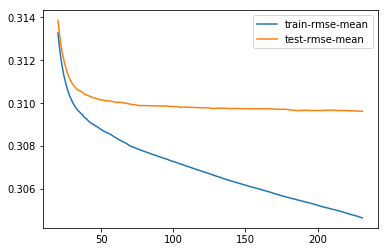

In [73]:
cv_xgb.iloc[20:, [0,2]].plot()

In [75]:
# Fit a model 
model_tmp = xgb.XGBClassifier(n_estimators=20, max_depth=2, learning_rate=0.6, subsample=0.7) #the params were tuned using xgb.cv

In [86]:
Xtest.shape

(80084, 97)

In [90]:
ms_k5 = ms.KFold(n_splits=5, shuffle=True)
xgb_trainscores = []
xgb_testscores = []
xgb_acttestscores = []
xgb_y_predicts = []
xgb_y_probs = []
for train_idx, test_idx in ms_k5.split(Xtrain, ytrain):
    x_train = Xtrain.iloc[train_idx]
    y_train = ytrain.iloc[train_idx]
    x_test = Xtrain.iloc[test_idx]
    y_test = ytrain.iloc[test_idx]
    model_tmp.fit(x_train, y_train)
    xgb_trainscores.append(model_tmp.score(x_train, y_train))
    xgb_testscores.append(model_tmp.score(x_test, y_test))
    xgb_acttestscores.append(model_tmp.score(Xtest, ytest))
    
    # predict for test data set
    xgb_y_predicts.append(model_tmp.predict(Xtest))
    xgb_y_probs.append(model_tmp.predict_proba(Xtest))

/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/anisha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

In [91]:
xgb_trainscores

[0.8872898684189988,
 0.8869620865656266,
 0.8871493904818393,
 0.886181653581407,
 0.8864799900106137]

In [92]:
xgb_testscores

[0.8849347568208779,
 0.8869950677405257,
 0.8850596241493414,
 0.8879940063682338,
 0.8881743256743256]

In [93]:
xgb_acttestscores

[0.8865701447828258,
 0.8864203694458312,
 0.8860708936595107,
 0.8864203694458312,
 0.8866200698951573]

In [94]:
for y_prob in xgb_y_probs:
    print(roc_auc_score(ytest, y_prob[:,1]))

0.6609347040909714
0.6639346900321985
0.6672718385743422
0.6607698916326472
0.661068126061521


## Grid Search

In [95]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV

In [105]:
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
%time grid_search_tree.fit(Xtrain, ytrain)

CPU times: user 4min 4s, sys: 2.38 s, total: 4min 7s
Wall time: 10min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=108,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [98]:
## best parameters
grid_search_tree.best_params_

{'criterion': 'gini', 'min_samples_leaf': 9, 'min_samples_split': 30}

In [99]:
## best score
grid_search_tree.best_score_

0.8718392957482675

In [104]:
## The overall accuracy on the training set:
grid_search_tree.score(Xtrain, ytrain)

0.8898156935218021

In [103]:
## The overall accuracy on the test set:
grid_search_tree.score(Xtest, ytest)

0.8726410384423365

In [ ]:
y_pprob = grid_search_tree.predict_proba(Xtest)
roc_auc_score(ytest, ypprob[:,1])